# "Spectral Coclustering to segment data science practitioners (Part 1)"

> "This is a tutorial on using Spectral Coclustering to segment different groups of data science practinioners based on data from the Kaggle ML and DS survey. Coclustering groups together both rows and columns, and allows us to focus on the features most pertinent to a given group. In part 1 of the tutorial, we focus on applying Spectral Coclustering on the Kaggle Survey dataset and delve into some of the practical considerations. In part 2 (soon to come!) we will dive deeper into the algorithm to understand how it works under the hood. The code for the tutorial is available on [GitHub](https://github.com/nikolay-shenkov/kaggle_survey_clustering)."

- toc: true
- branch: master
- badges: false
- comments: true
- categories: [survey, clustering, umap]
- image: images/spectral_coclustering_opening.png
- hide: false
- search_exclude: false

In [3]:
#collapse
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

from umap import UMAP
import umap.plot

from sklearn.cluster import SpectralCoclustering
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

alt.data_transformers.disable_max_rows();

<img class="docimage" src="../images/spectral_coclustering_opening.png" alt="" style="max-width: 60%"/>

Clustering is a messy business. It is difficult to find literature on best practices in a business context. How to choose a clustering model, and a proper distance measure for a given dataset? How to select the optimal number of clusters? In many papers, researchers apply clustering on datasets originally designed for classification, and measure clustering performance against the ground truth labels. This gives us some insight about the applicability of the clustering method on the type of data used in the study, but it does little to show how clustering can be applied in a real-world setting, where there are typically no labels, and we need to rely on our domain knowledge every step of the way. 

In practice, clustering is most useful when we don't have labels *and we are not even sure what the labels might be*. 

### Clustering on Survey Data
Every product manager in this world wants to understand their customers. A well-designed user survey is often a a good place to start. Survey data can be particularly valuable if it is coupled with additional metrics on how the survey respondents use the product in questions. 

In this tutorial we apply Spectral Coclustering on the 2019 Kaggle Machine Learning and Data Science Survey. At the end of each year Kaggle sends out this survey to their (very large) user base, with the aim of capturing a snapshot of the state of ML and DS. We don't have access to data on how the survey respondents use Kaggle, so instead we focus on the survey data itself.

#### Why Spectral Coclustering for survey data?

Spectral Coclustering clusters both the rows and the columns of a dataset, such that each row and each column belong to one cluster. If we sort both the rows and columns based on the cluster label, we obtain a block-diagonal structure. This structure can be clearly seen in [this example](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html) where spectral coclustering was applied on a synthetic dataset. In part 2 of this tutorial (soon to come), we will dive deeper into the inner workings of the algorithm.

Clustering both rows and columns is particularly useful with medium-to-large surveys that have a lot of multiple-choice questions, like the Kaggle survey. Here, we select 23 questions for the evaluation, where all the questions are , which results in 231 columns, once the multiple-choice questions are encoded as binary columns. Using standard clustering it will be difficult to compare the different user-clusters across so many different columns. With Spectral Clustering, we can focus on the responses that are most pertinent to a given cluster. Let's take a look at the toy example from the picture above. The corresponding table with responses is shown below. 

In [ ]:
#collapse
toy = pd.DataFrame({'Build prototypes': [1, 0, 1, 0, 0, 0], 
                    'Analyze understand': [1, 1, 0, 1, 0, 0],
                    'Tensorflow': [1, 0, 1, 0, 0, 1], 
                    'ggplot2': [0, 1, 0, 0, 1, 0],
                    'SQL': [0, 1, 0, 1, 1, 0],
                    'CNNs': [1, 0, 0, 0, 1, 1]})
toy.index.name = 'users'

In [3]:
toy

Build prototypes  Analyze understand  Tensorflow  ggplot2  SQL  CNNs
users                                                                      
0                     1                   1           1        0    0     1
1                     0                   1           0        1    1     0
2                     1                   0           1        0    0     0
3                     0                   1           0        0    1     0
4                     0                   0           0        1    1     1
5                     0                   0           1        0    0     1

If we run biclustering on this dataset, we might obtain two clusters, colorcoded orange and blue in the picture above. The blue cluster would contain rows (users) that tend to give positive responses (columns) such as "build prototypes" (*how do you spend most of your work time?*), "Tensorflow" (*what framework do you use?*), and "CNNs" (*what machine learning models do you use?*). Clustering both users and responses in this way can help us better characterize different groups. Similarly, the orange cluster would be described by "analyze and understand data", "SQL" and "ggplot2". Of course, the separation is not perfect, and you can see "blue" users occasionally selecting "orange" responses and vice versa. 

#### The Kaggle Survey questions 

One of the most important decision when clustering survey responses is choosing the questions used for clustering, and the ones used for analysis and validation post-clustering. If we were doing this in a professional setting, this would be a good time to discuss the survey goals with our teammates.

Most of the questions in this survey ask about things data science practitioners do at work: the types of problems they solve, frameworks they use, models they build. So we will use the responses to these questions for clustering. The full list of questions, color-coded based on my selection, is available [here](https://docs.google.com/spreadsheets/d/1GOdCE9WzEiHKwZm4u2079SrJ4UawtX4poEixjDKRHj8/edit?usp=sharing). 

The questions selected for analysis (post-clustering) relate to the users' prior experience (coding experience, formal education), as well as team size. This selection will allow us to make conclusions such as: *Users from cluster X focus on building deep learning prototypes using Tensorflow. Most of them have at least 2 years of experience with coding for data science.*

Question 5 ("select title most similar to your current role") is used to select an initial number of clusters. We do not use the job titles as ground truth labels, but we do expect some overlap between the Q5 responses and the cluster labels.

#### The respondents

Once we drop empty or nearly-empty responses, we are left with records from more than 18000 users. However, the survey was designed such that users who don't have lot of programming experience for data analysis (Q15) were not shown many of the questions. This effectively creates two groups: one that did not see most of the questions, and one that did. For the rest of the tutorial we focus on the more-experienced group since it likely better represents data science practitioners (and also filled out most of the questions, so we have more interesting data to work with). If you are curious about the preprocessing steps, you can find them in this [notebook](https://github.com/nikolay-shenkov/kaggle_survey_clustering/blob/master/survey_preprocess.ipynb).

In [ ]:
#collapse
df = pd.read_feather('data/encoded_subset.feather')
res = pd.read_feather('data/processed_subset.feather')

with open('data/responses.json', 'r') as f:
    uniques = json.load(f)
    
with open('data/short_questions.json', 'r') as f:
    short_qs = json.load(f)
    
qs = pd.read_csv('data/questions_only.csv').T.squeeze()

The questions used in clustering include single- or multi-selections, so each selection (column) can be encoded as binary.

In [8]:
df.head()

Q9_Part_1  Q9_Part_2  Q9_Part_3  Q9_Part_4  Q9_Part_5  Q9_Part_6  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          1          0          0          1   
4          1          0          0          0          1          1   

   Q9_Part_7  Q9_Part_8  Q12_Part_1  Q12_Part_2  ...  Q19_7  Q19_8  Q19_9  \
0          0          0           1           0  ...      0      1      0   
1          0          0           0           0  ...      0      1      0   
2          0          0           0           0  ...      0      1      0   
3          0          0           0           0  ...      0      0      0   
4          0          0           0           0  ...      0      1      0   

   Q19_10  Q19_11  Q22_0  Q22_1  Q22_2  Q22_3  Q22_4  
0       0       0      1      0      0      0      0  
1       0       0      0      1      0      0      0  
2       0       0      1      0      0      0      0  
3       0       0      1      0      0      0      0  
4       0       0      0      0      0      1      0  

[5 rows x 231 columns]

We also include mappings between question numbers and short summaries of the question, as well as the actual responses.

In [18]:
short_qs['Q20'], uniques['Q20_Part_1'], uniques['Q20_Part_2']

('viz libraries', 'Ggplot / ggplot2', 'Matplotlib')

## Selecting the number of clusters

There are a few important considerations when selecting the number of clusters:
* Most humans will struggle to keep track of more than about 7 or 8 user segments. Since the overall purpose of this analysis is to better understand our users, we will need to communicate our results to business leaders: slides will be drawn, presentations will be given, and reports will be written. Limiting ourselves to a few segments will help us draw a clearer picture of the user-base, especially when getting started.
* When doing the analysis, it is easy to overcluster (pick more clusters than what we expect the right number is), and then manually merge similar clusters together. Going in the opposite direction is much harder. 

Keeping these issues in mind, we will use the `Adjusted Rand Score` to measure the agreement between Q5 (job role) and the cluster labels (for the users) as we vary the number of clusters. We will use the agreement between Q5 and the cluster labels as a rough guide when selecting the cluster numbers, and not as a gold standard. If you are familiar with the adjusted rand score, feel free to skip ahead.

There are a number of cluster evaluation metrics that do not require ground truth labels, such as the `silhouette` coefficient and the `Calinski-Harabasz` index. Personally, I have not found them particularly useful, especially since each one tends to favor a particular type of clustering. If you have successfully used any of these metrics, let me know in the comments! 

### Rand Index

The Adjusted Rand Score is based on the Rand Index, so we need to understand the latter first. The Rand Index is a standard measure of the similarity of two partitions of a dataset. Let's suppose we have the following partitions:

In [101]:
from itertools import combinations
p1 = [0, 0, 0, 1, 1, 1, 2, 2, 2]
p2 = [0, 1, 0, 1, 1, 1, 2, 0, 2]

The Rand Index is calculated by looking at all pairs of items and finding:
* `a` = number of pairs that are in the **same partition** in `p1` and also the in **the same partition** in `p2`.
* `b` = number of pairs that are in **different partitions** in `p1` and also in **different partitions** in `p2`.

The following functions do this calculation.

In [4]:
def same_subset(items, part):
    """Given a pair of items, find out if they are in the same partition part"""
    i, j = items
    return part[i] == part[j]

def set_pairs(part, same=True):
    """Given a partition, find the set of pairs that are in the 
    same (same=True) or different (same=False) partitions"""
    if same:
        selection = lambda pair: same_subset(pair, part)
    else:
        selection = lambda pair: not same_subset(pair, part)
    n = len(part)
    return set(filter(selection, combinations(range(n), 2)))

For example, these are the set of pairs that are in the same partition in `p1`:

In [107]:
set_pairs(p1, same=True)

{(0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (6, 7), (6, 8), (7, 8)}

Once we can find the appropriate pairs, we can easily calculate the Rand Index. It is simply given by:

$$RI = \frac{a + b}{n_{pairs}} = \frac{2 (a + b)}{n (n - 1)}$$

where $n$ is the total number of items in our dataset.

In [112]:
def rand_index(p1, p2):
    """Compute the Rand index (not adjusted)"""
    assert len(p1) == len(p2) and len(p1) > 2
    a = len(set_pairs(p1, True) & set_pairs(p2, True))
    b = len(set_pairs(p1, False) & set_pairs(p2, False))
    n_pairs = len(p1) * (len(p1) - 1) / 2
    return (a + b) / n_pairs

rand_index(p1, p2)

0.75

So this metric varies between 0 and 1, where 1 indicates a perfect agreement between the two partitions. An important property is that the Rand index is independent of the actual cluster labels:

In [117]:
p3 = [7, 7, 7, 8, 8, 8, 9, 9, 9]
rand_index(p3, p2)

0.75

### Adjusted Rand Score

One of the issues with the Rand index is that it is not adjusted for chance. For example, we can take a look at random partitions of the same length as `p1` and `p2`, and with the same number of segments (3), and measure the Rand index between these.

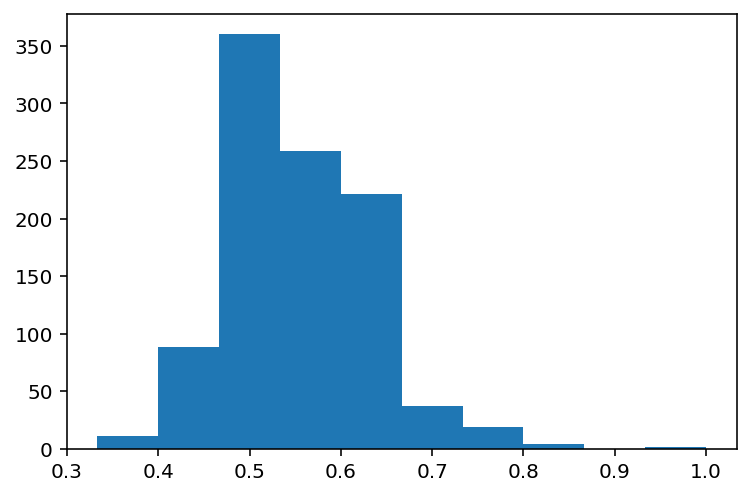

In [129]:
def rand_sample(u1, u2, part_len, n_iter):
    """Measures the Rand index between random sequences n_iter times.
    The two sequences have u1 and u2 unique elements, and are both of len = part_len."""
    scores = np.zeros(n_iter)
    for i in range(n_iter):
        s1 = np.random.choice(u1, part_len)
        s2 = np.random.choice(u2, part_len)
        scores[i] = rand_index(s1, s2)
    return scores

scores = rand_sample(3, 3, part_len=9, n_iter=1000)
plt.hist(scores, bins=10);

We can see that values between 0.4 and 0.7 are quite common when dealing with such a short sequence. We can try the same with longer sequences, and this is what we obtain:

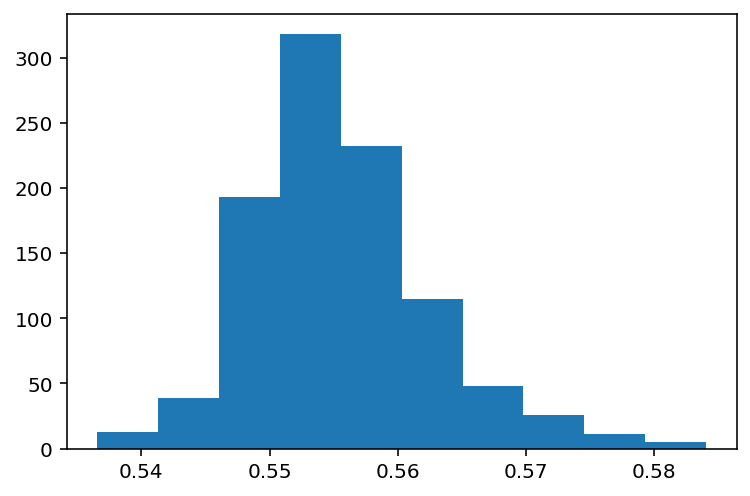

In [130]:
scores_long = rand_sample(3, 3, part_len=100, n_iter=1000)
plt.hist(scores_long, bins=10);

The score for the longer sequences is quite sharply peaked between 0.54 and 0.58, so it will be very unlikely to obtain a value of 0.75 by chance. 

The adjusted Rand index then takes this random variation into account as follows:

$$ARI = \frac{RI - E_{random}[RI]}{Max[RI] - E_{random}[RI]}$$

$ARI$ is simply a rescaled version of $RI$, computed by subtracting the mean $RI$ we would obtain by chance with random sequences (e.g. $E_{random}[RI] = 0.55$ for the example above), and by dividing this value by the difference between the maximum and the average $RI$. The division is done to increase the sensitivity of the metric. Note, this means that $ARI$ might be negative, if $RI < E_{random}[RI]$.

$ARI$ can be calculated exactly using the contingency table calculated from the two partitions. The formula can be found [here](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index), and it is used by the `scikit-learn` implementation. 

However, I find it easier to understand the $ARI$ correction using the `rand_sample` we saw above. This will give us an approximation, and it will be slower to compute since we need to sample many times to simulate the $RI$ distribution. On the other hand, we can clearly see the link between the code below and the $ARI$ definition:

In [187]:
def adjusted_rand(p1, p2, n_iter=5000):
    u1, u2 = len(np.unique(p1)), len(np.unique(p2))
    mean_rand = np.mean(rand_sample(u1, u2, len(p1), n_iter))
    ri = rand_index(p1, p2)
    return (ri - mean_rand) / (1 - mean_rand)

In the above code, I have used the simplification $Max[RI] = 1$. This would not work if the two sequences have different number of clusters.

In [197]:
adjusted_rand(p1, p2)

0.438622754491018

Note that the $ARI$ is substantially lower for our short sequences compared with the $RI = 0.75$. We can also calculate it on longer sequences and compare against the scikit-learn implementation.

In [201]:
p4, p5 = np.random.choice(3, 100), np.random.choice(3, 100)
p4[:50] = p5[:50]  # some overlap between the sequences

adjusted_rand(p4, p5, 1000)

0.21344424178478605

In [202]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(p4, p5)

0.22032319946248075

The values are off by about 0.005, quite close!

## Survey Analysis

We are now ready to do some clustering! We will fit SpectralCoclustering model using a range of clusters, and keep track of `ARI`.

Text(0.5, 1.0, 'Cluster metric against Q5 (Occupation)')

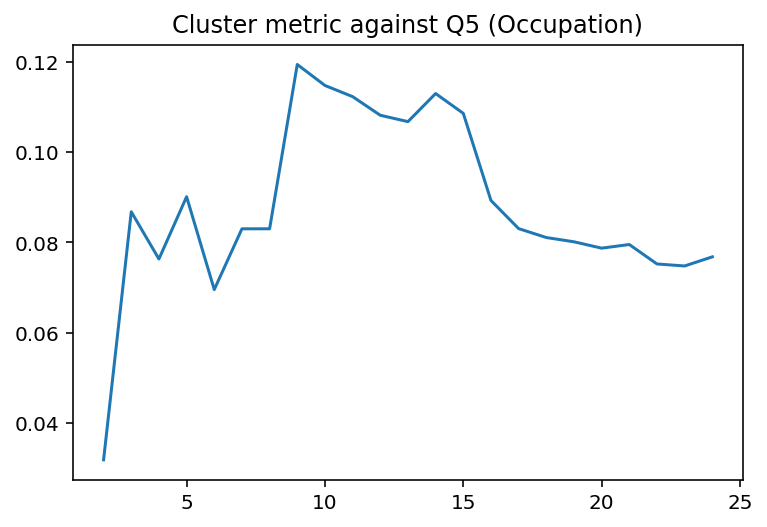

In [216]:
#collapse
def cocluster_iter(range_cl, data, **kwargs):
    """Fit SpectralCoclustering on a range of clusters"""
    for n_clusters in tqdm(range_cl):
        bicl = SpectralCoclustering(n_clusters=n_clusters, **kwargs)
        bicl.fit(data)
        yield n_clusters, bicl
        
def cluster_metrics(cocluster, metric, target):
    """Compute a given metric for a range of different n_clusters
    
    cocluster: coclustering generator that yields a fitted cluster object
    metric: metric callable
    target: target variable against which to compute metrics.
    """
    metrics = defaultdict(list)
    for n_clusters, bicl in cocluster:
        metrics['metric'].append(metric(bicl.row_labels_, target))
        metrics['n_clusters'].append(n_clusters)
    return pd.Series(metrics['metric'], index=metrics['n_clusters'])

cocluster = cocluster_iter(range(2, 25), df, random_state=0)
metrics = cluster_metrics(cocluster, adjusted_rand_score, res['Q5'].cat.codes)
ax = metrics.plot()
ax.set_title('Cluster metric against Q5 (Occupation)')

There is a sudden spike at `n_clusters=9`, so we will use that as a starting point.

In [110]:
%%time

bicl = SpectralCoclustering(n_clusters=9, random_state=0)
bicl.fit(df)

print('Column (question-response) cluster counts:', np.unique(bicl.column_labels_, return_counts=True)[1])
print('Row (user) cluster counts:', np.unique(bicl.row_labels_, return_counts=True)[1])

Column (question-response) cluster counts: [31 30 11  9 11  6 35 28 70]
Row (user) cluster counts: [1914 2611 1113  856  565  123 2703 2330 1471]
CPU times: user 10.7 s, sys: 3.01 s, total: 13.7 s
Wall time: 1.82 s


We obtain relatively balanced clusters, where the smallest user cluster contains 123 users, while the largest contains 2703 users. No single clusters dominates the questions or the users.

In [111]:
#collapse
row_labels = pd.Series(bicl.row_labels_, index=df.index, name='cluster')
analysis = pd.concat([res[['Q4', 'Q5', 'Q6', 'Q7', 'Q15']], row_labels], axis=1)
for name, col in analysis.iteritems():
    if hasattr(col, 'cat') and col.cat.ordered:
        analysis[f'{name}_order'] = col.cat.codes + 1
analysis.head(2)

Q4                 Q5                    Q6   Q7        Q15  \
0  Master’s degree  Software Engineer  1000-9,999 employees    0  1-2 years   
1  Master’s degree              Other    > 10,000 employees  20+  1-2 years   

   cluster  Q7_order  Q15_order  
0        6         1          3  
1        8         7          3

### Clusters and job roles

First, we study the relationship between `Q5` and the clusters. We use `altair` for plotting, because it allows us to easily add interactive elements such as tooltips to our plots. Here is a bar chart of the distribution of job roles per cluster. Since the cluster numbers are arbitrary, we sort the bars based on the proportion of students, since clusters with a large proportion of students should behave differently than those with few or no students. You can hover over the individual bars to get the actual user counts.

In [7]:
#collapse
sort_order = (analysis
              .groupby('cluster')['Q5']
              .apply(lambda s: (s == 'Student').mean())
              .sort_values())

alt.Chart(data=analysis[['Q5', 'cluster']], width=500).mark_bar(size=35).encode(
    x=alt.X('cluster:N', sort=sort_order.index.tolist()),
    y=alt.Y('count()', stack='normalize', title='Proportion (per cluster)'),
    color=alt.Color('Q5', scale=alt.Scale(scheme='tableau20')),
    tooltip=['Q5', 'count()']
)

alt.Chart(...)

We can see that clusters on the left are dominated by `Data Scientist`, and followed by `Software Engineer`, `Data Analyst` and `Research Engineer`. Besides `Student`, clusters on the right have higher `Not employed` proportion.

To get any further into the analysis, we need to look at the relationship between the row and column clusters. To do this, we need to do a bit of data wrangling. First, we are going to sort our data matrix according to the cluster labels.

In [112]:
#collapse
row_idx, col_idx = np.argsort(bicl.row_labels_), np.argsort(bicl.column_labels_)
df_sorted = df.iloc[row_idx, col_idx]
rows_sorted = bicl.row_labels_[row_idx]
cols_sorted = bicl.column_labels_[col_idx]

Next, we are going to create better labels for our columns. Currently, each column looks like this: `Q27_Part_4`; it is time-consuming to look up the questions and responses. Instead, what we want is something more readable, such as: `'NLP methods: Transformer language models (GPT-2, BERT,'` We have all the necessary information in the `uniques` and `short_qs` mappings.

In [9]:
#collapse
def col_label(col, n_words=5):
    """Make a human-friendly (but short) label for a given column.
    'Q26_Part_2' -> 'CV methods: Image segmentation methods (U-Net, Mask'
    """
    answer_words = uniques[col].split()
    answer_label = ' '.join(answer_words[:n_words])  # limit to n_words
    q_index = col.split('_')[0]  # 'Q26'
    q_label = short_qs[q_index]  # 'CV methods'
    return q_label + ': ' + answer_label

col_label('Q27_Part_3')

'NLP methods: Contextualized embeddings (ELMo, CoVe)'

Since some responses are inherently more popular than others, we are first going to subtract the average (across all users).

We can visualize the data matrix, after the subtraction, as follows:

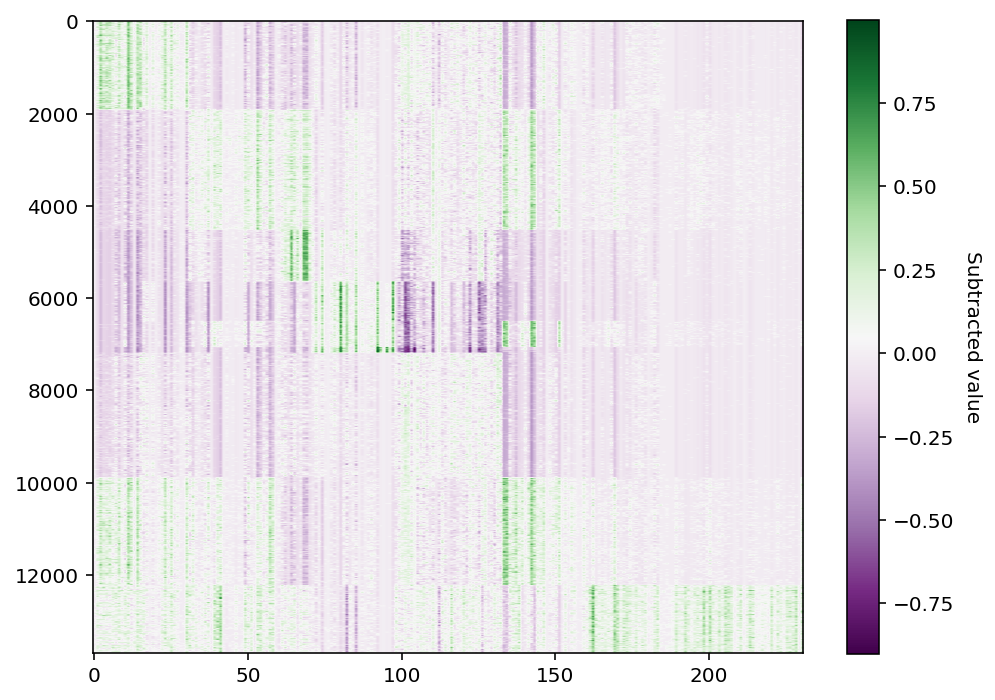

In [113]:
#collapse
df_center = df_sorted - df_sorted.mean()

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()
im = ax.imshow(df_center, aspect=0.015, cmap='PRGn')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Subtracted value', rotation=-90, va="bottom")
fig.tight_layout()

This heatmap gives us a good global picture of the dataset. Both rows and columns are sorted based on cluster: for example, `cluster 0` is at the top left. Most of the high values in green are along the block diagonal, as we would expect from the coclustering. However, there are a few green blocks away from the diagonal, in particular in the lower left corner. We will need to keep an eye on those especially when we analyze clusters 7 and 8, which are the ones with highest off-diagonal elements..

Next, we are going to display average values per cluster, so we can characterize each cluster.

In [11]:
#collapse
avg_cluster = df_center.groupby(rows_sorted).mean()
avg_cluster.columns = avg_cluster.columns.map(col_label)
avg_cluster.head(2)

used TPU: > 25 times  \
0              0.012916   
1             -0.009063   

   NLP methods: Encoder-decorder models (seq2seq, vanilla transformers)  \
0                                           0.125789                      
1                                          -0.082646                      

   CV methods: Image classification and other general  \
0                                           0.384853    
1                                          -0.185662    

   CV methods: Object detection methods (YOLOv3, RetinaNet,  \
0                                           0.225243          
1                                          -0.119416          

   CV methods: Image segmentation methods (U-Net, Mask  \
0                                           0.263230     
1                                          -0.125876     

   CV methods: General purpose image/video tools (PIL,  \
0                                           0.262646     
1                                          -0.136143     

   ML tools regular: Automated data augmentation (e.g. imgaug,  \
0                                            0.17058             
1                                           -0.09547             

   IDEs regular: PyCharm  ML algos regular: Recurrent Neural Networks  \
0               0.082068                                     0.246883   
1              -0.055362                                    -0.140269   

   ML algos regular: Generative Adversarial Networks  ...  \
0                                           0.116438  ...   
1                                          -0.059602  ...   

   Cloud platforms: VMware Cloud  ML products: Amazon SageMaker  \
0                      -0.010134                      -0.039215   
1                      -0.001221                       0.001486   

   ML products: Google Cloud Translation  ML products: RapidMiner  \
0                              -0.013583                -0.015739   
1                              -0.015535                 0.010130   

   ML products: Google Cloud Natural Language  \
0                                   -0.026209   
1                                   -0.021892   

   ML products: Google Cloud Speech-to-Text  ML products: Google Cloud Vision  \
0                                 -0.021901                         -0.022826   
1                                 -0.020930                         -0.021469   

   ML products: Google Cloud Machine Learning Engine  \
0                                          -0.033771   
1                                          -0.032381   

   Cloud platforms: SAP Cloud  Cloud products: AWS Elastic Compute Cloud (EC2)  
0                   -0.005115                                        -0.121536  
1                    0.001013                                         0.070342  

[2 rows x 231 columns]

From the above, we note that cluster 0 is much more likely to use Image classification than cluster 1, for example. Using `df_center` helps emphasize the differences between the clusters.

We are finally ready to summarize the clusters. Based on the heatmap, we will focus mostly on the cluster-specific responses (columns) that run along the block diagonal: for a cluster of users `c`, these are the columns that belong to column cluster `c`. We will also keep an eye for high values in the rest of the columns. Below is a simple function which will print a cluster summary, that is, the columns with the highest average (centered) score for a given cluster.

In [12]:
#collapse
def get_cluster_cols(c):
    """Split the average responses for a given cluster into two groups:
    specific: these are the responses (columns) specific to a given cluster
    others: the rest of the responses, that belong to a different cluster"""
    specific = avg_cluster.loc[c, cols_sorted == c].sort_values(ascending=False)
    others = avg_cluster.loc[c, cols_sorted != c].sort_values(ascending=False)
    return specific, others

def print_summary(c, n_specific=10, n_other=5):
    print('Cluster', c)
    specific, others = get_cluster_cols(c)
    print('Cluster-specific:')
    print(specific.head(n_specific).round(3).to_string())
    print()
    print('Others (off-diagonal):')
    print(others.head(n_other).round(3).to_string())
    print()

In [13]:
print_summary(0)

Cluster 0
Cluster-specific:
ML algos regular: Convolutional Neural Networks        0.494
CV methods: Image classification and other general     0.385
hardware: GPUs                                         0.343
ML frameworks: Keras                                   0.309
hosted notebooks: Google Colab                         0.303
ML frameworks: TensorFlow                              0.287
ML algos regular: Dense Neural Networks (MLPs, etc)    0.268
CV methods: Image segmentation methods (U-Net, Mask    0.263
CV methods: General purpose image/video tools (PIL,    0.263
ML algos regular: Recurrent Neural Networks            0.247

Others (off-diagonal):
hosted notebooks: Kaggle Notebooks (Kernels)                        0.188
viz libraries: Matplotlib                                           0.182
NLP methods: Word embeddings/vectors (GLoVe, fastText, word2vec)    0.156
language recommend: Python                                          0.121
IDEs regular: Jupyter (JupyterLab, Jupyter

Based on this, users in cluster 0 are very focused on deep learning and computer vision. Let's contrast them with users from cluster 7. This is one of the clusters with responses overlapping with those of cluster 0.

In [72]:
print_summary(2, n_other=10)

Cluster 2
Cluster-specific:
language regular: R                                        0.577
IDEs regular: RStudio                                      0.573
viz libraries: Ggplot / ggplot2                            0.525
language recommend: R                                      0.272
platform courses: DataCamp                                 0.193
ML frameworks: Caret                                       0.183
viz libraries: Shiny                                       0.158
ML frameworks: RandomForest                                0.129
platform courses: edX                                      0.070
primary tool: Advanced statistical software (SPSS, SAS,    0.059

Others (off-diagonal):
hardware: None / I do not                                             0.252
hosted notebooks: None                                                0.193
ML algos regular: Linear or Logistic Regression                       0.158
used TPU: Never                                                       

We see that cluster 7 is also focused on deep learning as well as `experimentation and iteration` and `research`. When we go back to our job role bar-chart, we note that cluster 0 contains the highest proportion of students across all clusters, whereas cluster 7 is a mix of mostly data scientists, software engineers and research scientists.

By keeping track of the off-diagonal elements, we are able to better characterize the two clusters. We can go a little further by examining differences in responses to Q15 ("years of writing code for data analysis")

In [1]:
# collapse
def stacked_bar(data, q):
    """Stacked bar with order information"""
    return alt.Chart(data=data).mark_bar(size=25).encode(
        x=alt.X('cluster:N', sort=sort_order.index.tolist()),
        y=alt.Y('count()', title='Proportion (per cluster)', stack='normalize'),
        # need to provide a list with ordered categories to display correctly
        color=alt.Color(f'{q}:O', scale=alt.Scale(scheme='inferno'), 
                        sort=list(data[q].cat.categories)),
        tooltip=[q, 'count()'],
        # force an order on a categorical variable
        order=f'{q}_order'
    ).proporties(
        width=350, 
        height=200, 
        title=short_qs[q]
    )

#### TODO: Combine buckets for Q15!

In [306]:
#collapse
stacked_bar(analysis, 'Q15')

alt.Chart(...)

The majority of cluster 0 users (65%) are fairly new to programming for data analysis (<= 2 years). In the case of cluster 7, this proportion is much smaller, at about 35%. In summary, there is some overlap in terms of the technologies that the two clusters are using but their experience and job roles are substantially different. 

We can use this procedure (examine highest responses per cluster, cross-reference with the analysis questions) to characterize the rest of the clusters. This is the summary that I came up with (in about 30 minutes).

In [38]:
print_summary(4, n_specific=5, n_other=15)

Cluster 4
Cluster-specific:
hosted notebooks: None                                                0.433
ML tools regular: None                                                0.392
language regular: Other                                               0.122
primary tool: Business intelligence software (Salesforce, Tableau,    0.093
language recommend: SQL                                               0.087

Others (off-diagonal):
ML frameworks: None                                           0.576
AutoML regular: None                                          0.531
ML products: None                                             0.484
viz libraries: None                                           0.451
Cloud products: None                                          0.451
Big data products: None                                       0.447
ML algos regular: None                                        0.396
Cloud platforms: None                                         0.349
hardware: None / I do no

## Summary of results

### Learners: Cluster 0, 6

These two clusters have the highest proportion of students (at about 50%). These are also the groups with least experience in terms of years of programming (`<= 2 years` for the majority of users in both clusters). Both groups are active users of Kaggle Notebooks and Courses. 

Cluster 0 users tend to focus on deep learning, especially on computer vision tasks (image classification: `0.49`, image segmentation: `0.26`). They use Keras (`0.31`) and Tensorflow (`0.29`) for building models.

Respondents from Cluster 6 use more traditional Python data analysis tools, such as Matplotlib (`0.15`), Seaborn (`0.15`) and Scikit-learn (`0.12`).

### Beginners: Clusters 3, 4, 5

These are the smallest clusters and together account for about 11% of the respondents.  These users respond to most of the questions with None. Excel (or other related products) is the main software tool that show up in all three clusters, especially in cluster 5 with a score of `0.40`. The most common job roles are: Business/Data Analyst, Software Engineer, Student. 

Depending on the business purposes, it might be reasonable to merge these clusters together in a single group. There are a few differences, however. For example, users from cluster 4 have longer coding experience (more than half of them have 3+ years of coding experience), and there are almost no students in that cluster. 


### R Users: Cluster 2

This is the R cluster! Examining the highest responses makes this clear: R as language regularly used (`0.58`), RStudio as the IDE (`0.57`), ggplot2 for visualization (`0.53`), and again, R, as the language to recommend (`0.27`). In terms of ML algorithms, these users are more likely to fit linear and logistic regression models (`0.16`). 

Here, we see a split the job role distribution between students, data scientists and data analysts. In terms of coding experience, this cluster is in-between the beginner clusters above and the professional clusters we will examine below.


### Professionals: Clusters 1, 7, 8

These are the most experienced groups of users. Each of these clusters have unique characteristics, but first we review some of the similarities. These are users with the most coding experience (with more than 60% of users in each group having 3+ years of experience). There are no students in these clusters, and conversely, these are clusters with largest proportions of data scientists (almost half of users in cluster 1). Now, onto the unique aspects of each cluster:

**Cluster 7 Researchers**

We mentioned cluster 7 earlier when we contrasted it with cluster 0. Cluster 7 users focus on experimentation and iteration to improve ML models (`0.28`), and do research to advance the state of the art in ML (`0.18`). Curiously, these are also the users that are most likely to have an employer with a mature ML ecosystem (`0.16`). The research focus is deep learning, and captures almost all domains, libraries, and models of deep learning. On the other hand, these users are not likely to use cloud products (cloud products - None: `0.27`) and big data products (big data products - None: `0.45`). Perhaps, this is because these users are building custom models and products that are not well-supported by mainstream clod services.

**Cluster 1 Analysts and prototype builders**

Cluster 1 users focus on analyzing data to influence product decisions (`0.34`) and building prototype to explore ML applications (`0.25`). There is some overlap with cluster 7, but it appears that cluster 1 users are focusing on tabular data: they use SQL regularly (`0.17`), as well as all major SQL databases. They also use algorithms traditionally applied to tabular data such as decision trees and random forests (`0.20`), and gradient boosting (`0.16`). They are also more likely to use R regularly (`0.24`).


**Cluster 8 Deployment and Cloud**

Users in cluster 8 focus on putting models to production using the cloud. Virtually all cloud-related platforms, services and products fall under this cluster. These users are also more likely to use use AutoML products (Auto-Sklearn: `0.25` and Google AutoML: `0.24`). These users focus on building the necessary data infrastructure (`0.22`) as well as analyzing data to influence product decisions (`0.21`). 

Interestingly, Google Cloud is more popular with these users (`0.64`) compared to Amazon Web Services (`0.57`), and Microsoft Azure (`0.38`), which is very different from the market share of each of these cloud providers (AWS is well ahead, followed by Microsoft and Google). The over-representation of Google Cloud in this survey might be due to (1) Google Cloud's strong offerings in the machine learning space and (2) the fact that Kaggle is part of Google and it promotes some of the Google products.

We should also point out that this is the group with the highest response rates across all clusters (note all the green values for the last row-block in the heatmap). 

## UMAP projection

We are going to conclude our analysis by creating a [UMAP](https://umap-learn.readthedocs.io/) projection of our dataset on the 2D plane. UMAP is a very useful nonlinear dimensionality reduction technique and deserves a tutorial of its own. We are not going to delve into the details here, and simply use it with these goals in mind:

* Assess the agreement between clustering labels and UMAP projection. If the two agree with each other, we can be more confidentent in our analysis.
* UMAP projections, especially plots of the underlying connectivity matrix, often look (to use the technical term) *pretty cool*. Plots that are *pretty cool* often attract attenion: they can be included in title slides or document highlights and help get more people excited about out data analysis. 

### Jaccard coefficient as a distance measure

Perhaps the most important UMAP parameter is the distance measure. Our dataset includes binary features only (yes / no selections) so the Jaccard coefficient is a good choice. It is defined as the size of the intersection of two sets $u$ and $v$, divided by the size of their union:

$$J(u, v) = \frac{|u \cap v|}{|u \cup v |}$$


Wikipedia has a nice [graphic](https://en.wikipedia.org/wiki/Jaccard_index) of the Jaccard coefficient. In our case, the numerator will count the number of matches (shared selections) between users $u$ and $v$. The denominator will normalize this count by the total number of unique selections of both $u$ and $v$. It is easier to have more matches with a user that has made a lot of positive selections, so we need the denominator to control for this effect.

Let's compute the Jaccard index for a few of the users in the toy dataset to gain a better intuition. Here is the dataset again

In [4]:
#hide_input
toy

Build prototypes  Analyze understand  Tensorflow  ggplot2  SQL  CNNs
users                                                                      
0                     1                   1           1        0    0     1
1                     0                   1           0        1    1     0
2                     1                   0           1        0    0     0
3                     0                   1           0        0    1     0
4                     0                   0           0        1    1     1
5                     0                   0           1        0    0     1

The Jaccard index for users 0 and 1 is: 
$$J(u_0, u_1) = \frac{1}{6} = 0.167$$
because they have a single match (Analyze / understand data), and a total of 6 unique selections. On the other hand: $$J(u_0, u_2) = \frac{2}{4} = 0.50$$ 
Note that both the numerator and the denominator changed because the intersection is larger, while the union is smaller.

The Jaccard index is closely related to cosine similarity, which works with continuous features, in addition to binary label sets. Indeed, using `metric='cosine'` in the projection below results in a very similar projection.

In [170]:
#collapse
%%time

mapper = UMAP(n_neighbors=15, min_dist=0.1, 
              metric='jaccard', random_state=0).fit(df)

/home/nikolay/.pyenv/versions/3.7.4/envs/main/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CPU times: user 19.6 s, sys: 1.69 s, total: 21.3 s
Wall time: 19 s


### UMAP projection and cluster labels

First, we are going to plot the projection, colored by the cluster labels.

<AxesSubplot:>

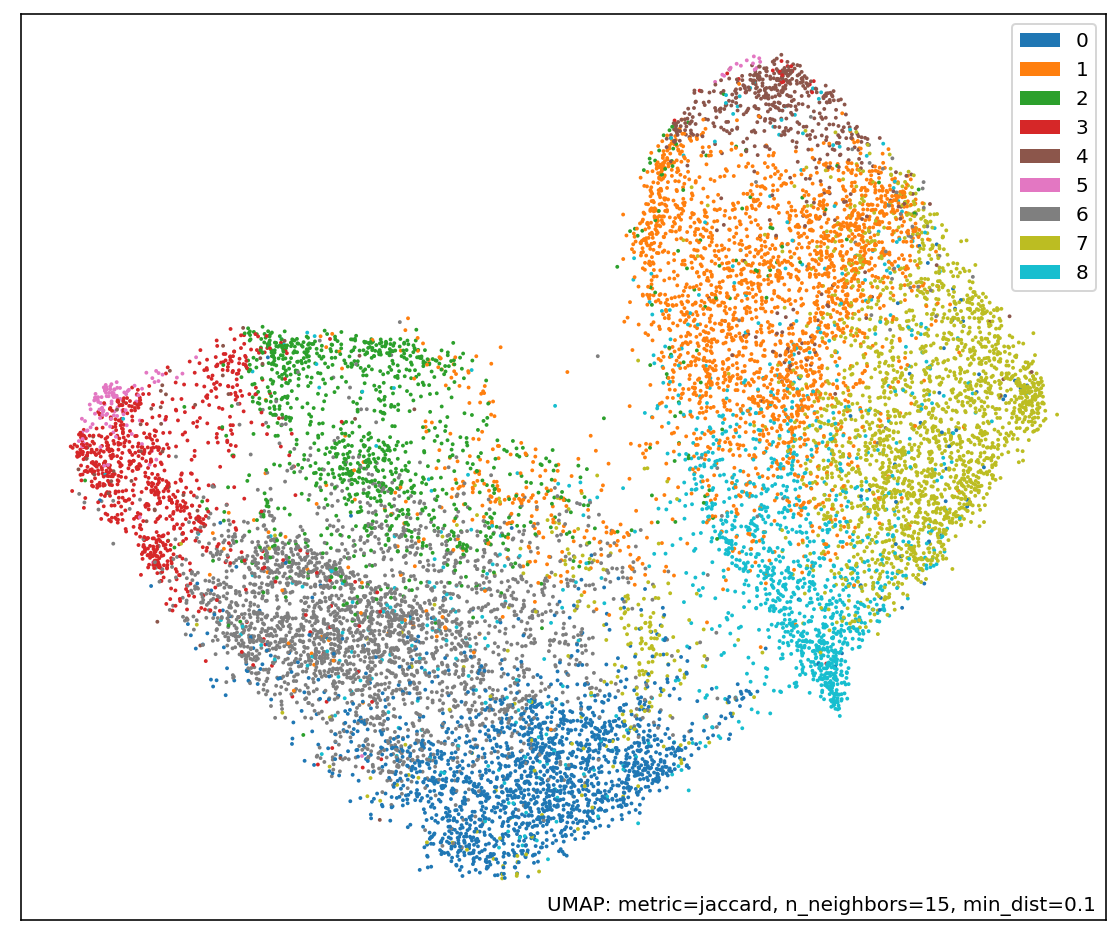

In [186]:
#collapse
umap.plot.points(mapper, labels=row_labels, 
                 color_key_cmap='tab10', width=700, height=600);

Overall, there is a good agreement between the cluster labels and the projection. Here are some of my observations: 
* There are two main structures in the projection (two wings of a butterfly?), with a clear separation between them. One includes mostly clusters with students (0, 2, 3, 5, 6) and the other one includes clusters without. 
* Learners (clusters 0 and 6) are neighboring each other in the projection, and so are the Professionals (1, 7 and 8).
* The Beginners (3, 4, 5) are split into two groups, with clusters 3 and most of 5 on the one side.

### UMAP connectivity matrix

We can also examine the connectivity matrix used by UMAP to create the projection. 

<AxesSubplot:>

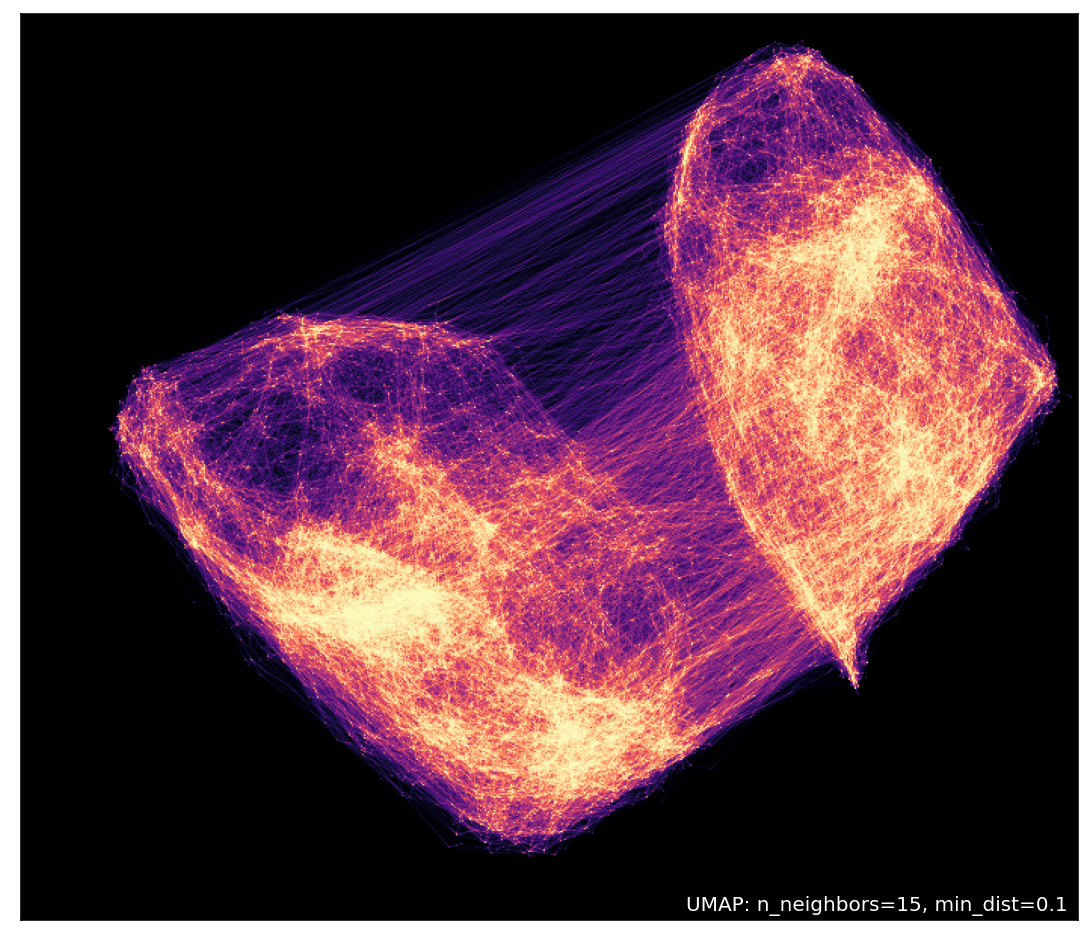

In [184]:
#collapse
umap.plot.connectivity(mapper, edge_cmap='magma', background='black', width=700, height=600);

Indeed, the connectivity matrix looks cool! It will make a fine presentation highlight. 

In addition to the dense local connections, there are many connections between the two large structures that run in parallel to each other. This provides some additional information about the structure of the data which is lost in the 2D scatter plot. These parallel connections are encouraging because it appears that some of them link cluster 4 with 3 and 5 (near the top of the structure) suggesting that there is indeed a similarity between these, as noted previously. 

### Conclusion